# **Hugging Face Blog - Quick Scan**

- Demos which I can try to make-

1. Voice Conversion
2. ASR
3. TTS

1. SpeechT5 is inspired by text-to-text T5 model -- released by Microsoft Asia Research
2. learns from speech as well as the text , unlike previous models which learned speech representations directly from the audio
3. at the heart of T5 model is a regular encoder-decoder model, just like T5
4. To make it possible for the same Transformer to deal with both text and speech data, so-called pre-nets and post-nets were added.
5. pre-net: convert the input text or speech into the hidden representations used by the Transformer.
6. post-net: takes the outputs from the Transformer and turns them into text or speech again.



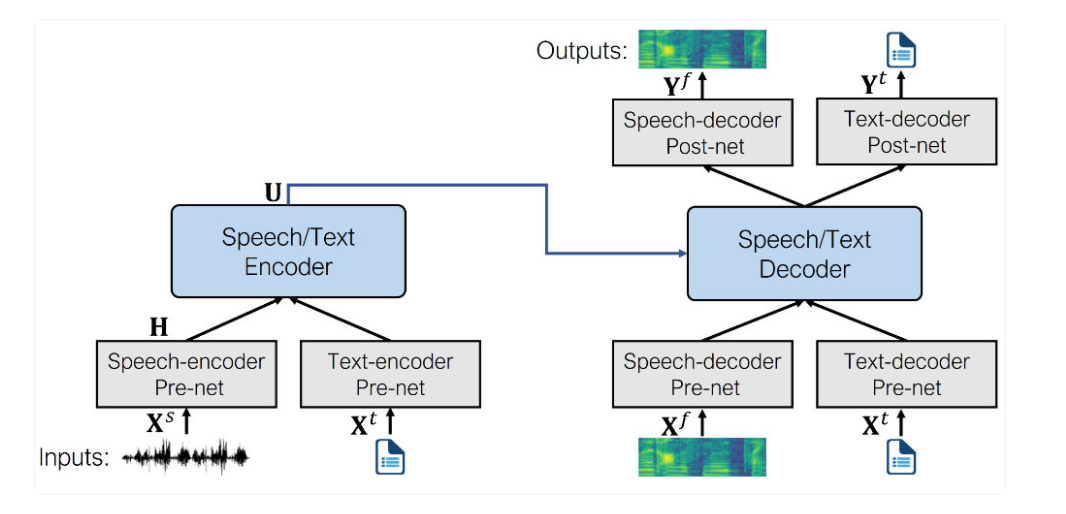

1. Pre-training and Fine-tuning: During pre-training, all pre-nets and post-nets are used simultaneously in the SpeechT5 framework. After pre-training, the entire encoder-decoder backbone is fine-tuned on a specific task.

2. Task-specific Adaptation: In the fine-tuning phase, only the pre-nets and post-nets specific to the given task are used. For example, when using SpeechT5 for text-to-speech, the text encoder pre-net is used for text inputs, while the speech decoder pre-net and post-nets are used for speech outputs.

3. Different Models for Different Tasks: Although the fine-tuned models initially share the same set of weights from the shared pre-trained model, they end up being quite different. Simply swapping the pre-nets and post-net won't result in a functional model for a different task. SpeechT5 offers flexibility, but there are limitations to how interchangeably the models can be used.

# Text-to-Speech

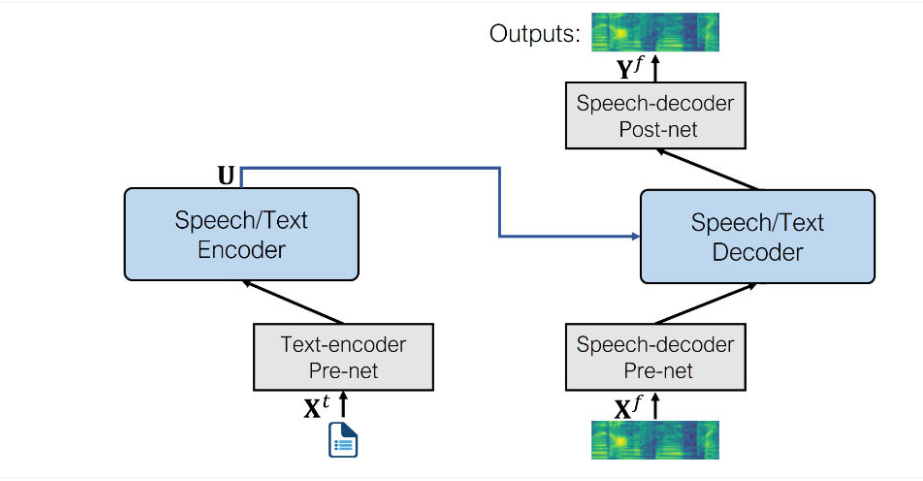

For the TTS task, the model uses the following pre-nets and post-nets:

1. Text Encoder pre-net: A text embedding layer that maps text tokens to the hidden representations that the encoder expects.

2. Speech Decoder pre-net: This takes a log mel spectrogram as input and uses a sequence of linear layers to compress the spectrogram into hidden representations. This design is taken from the Tacotron 2 TTS model.

3. Speech Decoder post-net: This predicts a residual to add to the output spectrogram and is used to refine the results, also from Tacotron 2.


In [30]:
!pip install -q git+https://github.com/huggingface/transformers.git sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [31]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

In [32]:
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")


In [33]:
#Tokenizing input text
inputs = processor(text = "Need to make a quick exit!", return_tensors="pt")
inputs

{'input_ids': tensor([[ 4, 48,  5,  5, 14,  4,  6,  8,  4, 18,  7, 28,  5,  4,  7,  4, 45, 16,
         10, 17, 28,  4,  5, 37, 10,  6, 44,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [34]:
!pip install -q datasets --upgrade

In [35]:
from datasets import load_dataset

In [36]:
 embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")

In [37]:
embeddings_dataset

Dataset({
    features: ['filename', 'xvector'],
    num_rows: 7931
})

In [38]:
import torch

In [39]:
speaker_embeddings = torch.tensor(embeddings_dataset["xvector"][100]).unsqueeze(0)

In [40]:
speaker_embeddings

tensor([[-0.0737,  0.0094,  0.0250,  0.0373,  0.0065, -0.0492, -0.0576,  0.0293,
          0.0631,  0.0171, -0.0963, -0.0919,  0.0604,  0.0171,  0.0287,  0.0550,
          0.0269,  0.0211,  0.0166,  0.0176,  0.0332,  0.0182, -0.0166, -0.0343,
         -0.0539, -0.0046, -0.0678, -0.0071,  0.0638,  0.0540, -0.0021,  0.0765,
          0.0115,  0.0184,  0.0198, -0.0548,  0.0157,  0.0487,  0.0031, -0.0469,
          0.0166, -0.0089,  0.0332,  0.0376,  0.0327, -0.1156, -0.0182,  0.0110,
         -0.1262,  0.0439,  0.0065,  0.0151,  0.0203,  0.0345, -0.0980, -0.0281,
         -0.0182,  0.0164,  0.0208,  0.0427,  0.0152, -0.0079, -0.0164, -0.0007,
          0.0353,  0.0220,  0.0401, -0.0402, -0.0505, -0.0643,  0.0124,  0.0110,
          0.0222,  0.0125,  0.0144,  0.0339,  0.0450,  0.0140, -0.0906, -0.0928,
         -0.0754, -0.0412, -0.0558, -0.0671, -0.0280, -0.0714, -0.0553,  0.0111,
          0.0233, -0.0414,  0.0266, -0.0558,  0.0142, -0.0770,  0.0559, -0.0499,
          0.0600,  0.0056, -

In [41]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [42]:
spectrogram

tensor([[-2.1874, -2.2681, -2.3030,  ..., -3.3564, -3.4093, -3.6181],
        [-2.0710, -2.1540, -2.1608,  ..., -3.2969, -3.3299, -3.5824],
        [-1.5542, -1.6362, -1.7345,  ..., -3.2067, -3.2665, -3.5298],
        ...,
        [-0.3001, -0.6546, -0.8610,  ..., -2.5777, -2.6524, -2.9399],
        [-0.2907, -0.5711, -0.8163,  ..., -2.5849, -2.6670, -2.9478],
        [-0.2816, -0.5522, -0.8075,  ..., -2.5459, -2.6251, -2.9087]])

In [43]:
spectrogram.shape

torch.Size([278, 80])

- 224 frames and 80 frequency bins

1. To convert the predicted log mel spectrogram into an actual speech waveform, we need a vocoder.

2. In theory, we can use any vocoder that works on 80-bin mel spectrograms

In [44]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [45]:
with torch.inference_mode():
  speech = vocoder(spectrogram)

In [46]:
speech

tensor([-0.0004,  0.0003,  0.0006,  ...,  0.1116,  0.1146,  0.0917])

## Alternatively

In [46]:
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings)

In [47]:
import soundfile as sf
sf.write("tts_example1.wav", speech.numpy(), samplerate=16_000)

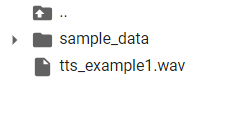

In [48]:
from IPython.display import Audio
audio = Audio("/content/tts_example1.wav")

In [49]:
audio

Note: Key is to use right speaker embeddings

# Speech-to-Speech Voice Conversion

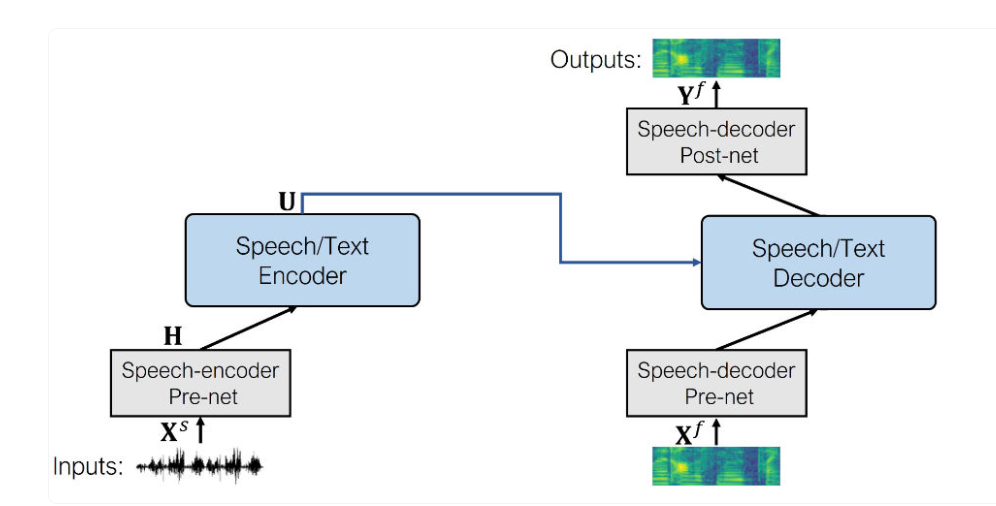

1. speech encoder pre-net
2. speech decoder pre-net
3. speech decoder post-net

In [50]:
from transformers import SpeechT5Processor, SpeechT5ForSpeechToSpeech

In [51]:
model = SpeechT5ForSpeechToSpeech.from_pretrained("microsoft/speecht5_vc")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_vc")

Some weights of SpeechT5ForSpeechToSpeech were not initialized from the model checkpoint at microsoft/speecht5_vc and are newly initialized: ['speecht5.encoder.prenet.pos_sinusoidal_embed.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")

In [54]:
dataset

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
    num_rows: 73
})

In [56]:
example = dataset["audio"][10]

In [57]:
example

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/dfbece23564f422bc5794f3090902cd16d52d86767b746125ebc2ff3ea5f89ef/dev_clean/1272/128104/1272-128104-0010.flac',
 'array': array([-0.00018311, -0.00027466, -0.00012207, ..., -0.00033569,
        -0.00036621, -0.00036621]),
 'sampling_rate': 16000}

In [64]:
Audio(data=example['array'], rate=example['sampling_rate'])

In [69]:
#Preprocessing the audio
inputs = processor(audio = dataset[10]["audio"]["array"], sampling_rate = dataset[10]["audio"]["sampling_rate"], return_tensors="pt")


In [70]:
inputs

{'input_values': tensor([[-0.0002, -0.0003, -0.0001,  ..., -0.0003, -0.0004, -0.0004]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}

In [71]:
inputs["attention_mask"]

tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [73]:
import torch
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)


In [74]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")


In [75]:
speech = model.generate_speech(inputs["input_values"], speaker_embeddings, vocoder=vocoder)

import soundfile as sf
sf.write("speech_converted.wav", speech.numpy(), samplerate=16000)


In [77]:
Audio("/content/speech_converted.wav", rate=16000)